# Modeling Diabetes Risk from BRFSS (2019–2023)

## 1. Introduction

The Behavioral Risk Factor Surveillance System (BRFSS) is a large health-related telephone survey dataset collected annually by the Unite States Centers for Disease Control and Prevention (CDC). In this notebook, we explore 5 years of BRFSS data to build a logistic regression model predicting diabetes based on health-related features.

We'll use basic preprocessing, class balancing with SMOTE, and evaluate using precision, recall, and ROC curves.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import time

from imblearn.over_sampling import SMOTE
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

In [2]:
# Globals
SEED = 22
start_time = time.time()

## 2. Load the Cleaned Dataset

In [3]:
data_dir = Path("../data/cleaned")
years = [2019, 2020, 2021, 2022, 2023]

dfs = []
for year in years:
    file = data_dir / f"brfss_cleaned_{year}.csv"
    print(f"Loading {file}")
    df = pd.read_csv(file, low_memory=False)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"\nMerged shape: {df_all.shape}")
df_all.head()

Loading ../data/cleaned/brfss_cleaned_2019.csv
Loading ../data/cleaned/brfss_cleaned_2020.csv
Loading ../data/cleaned/brfss_cleaned_2021.csv
Loading ../data/cleaned/brfss_cleaned_2022.csv
Loading ../data/cleaned/brfss_cleaned_2023.csv

Merged shape: (2132659, 14)


,year,age,sex,educa,bmi,bmi_cat,drink_any,fruit_low,veg_servings,snap_used,smoke_100,exercise_any,diabetes,food_insecurity
0,2019,85.0,Female,Less than HS,28.17,Overweight,No,>= 1x per day,1.14,NaN,Yes,No,No,NaN
1,2019,72.0,Female,Some college,18.54,Normal,No,>= 1x per day,1.21,NaN,No,Yes,No,NaN
2,2019,67.0,Female,College graduate,31.62,Obese,No,>= 1x per day,1.64,NaN,No,Yes,Yes,NaN
3,2019,85.0,Female,Some college,20.30,Normal,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
4,2019,85.0,Female,Some college,21.48,Normal,No,>= 1x per day,1.78,NaN,Yes,No,No,NaN


## 3. Exploratory Data Analysis (EDA)

In [4]:
# Check target class balance
print(df_all["diabetes"].value_counts())
print(df_all["diabetes"].value_counts(normalize=True))

diabetes
No     1826551
Yes     306108
Name: count, dtype: int64
diabetes
No     0.856467
Yes    0.143533
Name: proportion, dtype: float64


In [5]:
# Target counts by year
print(df_all.groupby("year")["diabetes"].value_counts(normalize=True))

year  diabetes
2019  No          0.853427
      Yes         0.146573
2020  No          0.861725
      Yes         0.138275
2021  No          0.859669
      Yes         0.140331
2022  No          0.853632
      Yes         0.146368
2023  No          0.854191
      Yes         0.145809
Name: proportion, dtype: float64


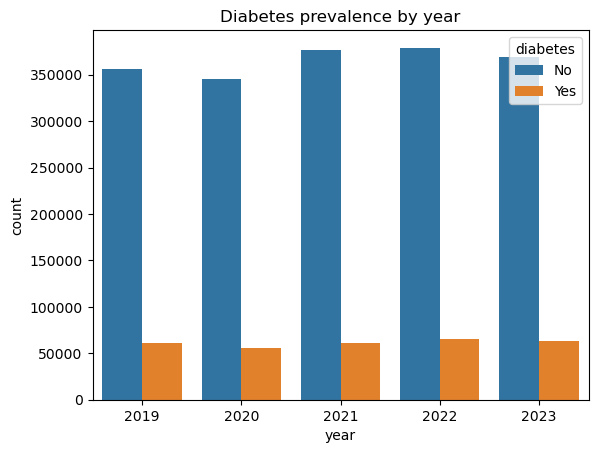

In [6]:
sns.countplot(data=df_all, x="year", hue="diabetes")
plt.title("Diabetes prevalence by year")
plt.show()

## 4. Feature Preparation

### 4.1 Feature Engineering and Encoding

There are only seven features pertinent to diabetes that are common to all the years.

In [7]:
df_model = df_all.copy()

# Include only features common to all years
common_features = ["age", "sex", "educa", "bmi", "bmi_cat", "smoke_100", "exercise_any"]

df_common = df_model.dropna(subset=common_features + ["diabetes"])
df_common = df_common[common_features + ["diabetes"]].copy()

### Convert binary and categorical vars
binary_cols = ["smoke_100", "exercise_any", "diabetes"]
for col in binary_cols:
    df_common[col] = (
        df_common[col]
        .astype(str)
        .str.strip()
        .str.replace('"', "")
        .map({"Yes": 1, "No": 0})
    )

In [8]:
### Convert categorical strings to dummy vars
df_common = pd.get_dummies(
    df_common, columns=["sex", "educa", "bmi_cat"], drop_first=True
)
print(df_common.shape)
print(df_common.head())
print("Any NaNs in X?", df_common.drop(columns=["diabetes"]).isna().any().any())

(1842899, 12)
    age    bmi  smoke_100  exercise_any  diabetes  sex_Male  educa_HS or GED  \
0  85.0  28.17          1             0         0     False            False   
1  72.0  18.54          0             1         0     False            False   
2  67.0  31.62          0             1         1     False            False   
4  85.0  21.48          1             0         0     False            False   
6  72.0  32.98          1             1         1      True            False   

   educa_Less than HS  educa_Some college  bmi_cat_Obese  bmi_cat_Overweight  \
0                True               False          False                True   
1               False                True          False               False   
2               False               False           True               False   
4               False                True          False               False   
6               False               False           True               False   

   bmi_cat_Underweight  

In [9]:
# Split features and target
X = df_common.drop(columns=["diabetes"])
y = df_common["diabetes"]

## 5. Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

## 6. Logistic Regression Model (for comparison with XGBoost in Notebook 01)

### Why SMOTE?

In this dataset, the number of people with diabetes is much smaller than those without — a classic case of **class imbalance**. Training a model on imbalanced data can cause it to ignore the minority class (those with diabetes), resulting in poor recall or sensitivity.

**SMOTE** (Synthetic Minority Over-sampling Technique) addresses this by generating new, synthetic examples of the minority class. It does this by interpolating between real observations rather than duplicating them, helping the model learn decision boundaries that better reflect both classes.

We apply SMOTE *after* splitting the data into training and testing sets to ensure no data leakage.


In [11]:
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

## 7. Model Evaluation

### 7.1 Precision-Recall Curve

Precision and recall measure two different kinds of model performance:

- **Precision** answers: *Of all the cases the model predicted as positive (diabetes), how many were actually positive?*  
  A low precision means many **false positives** — people incorrectly flagged as having diabetes.

- **Recall** answers: *Of all the actual positive cases (true diabetes), how many did the model correctly identify?*  
  A low recall means many **false negatives** — people with diabetes that the model missed.

These two metrics often trade off against each other depending on the **threshold** we use to convert predicted probabilities into binary decisions. This plot shows how **precision** and **recall** change as we vary the threshold from 0 to 1.

The red dot marks the threshold where **precision and recall are approximately equal** (what we might call a **tuned threshold**), representing a balance between false positives and false negatives. This value can serve as a more informative alternative to the default threshold of 0.5, especially when both types of errors are equally important to minimize.


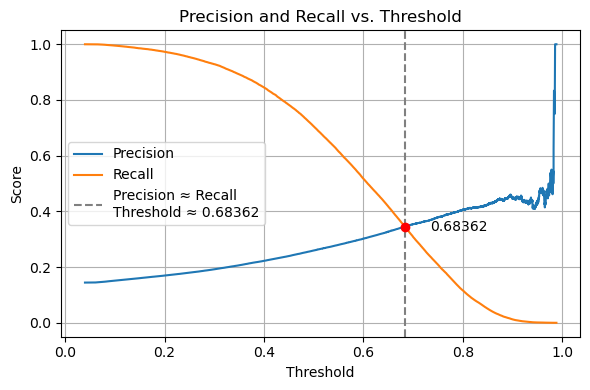

In [12]:
y_probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate where precision and recall are closest
pr_diff = np.abs(precision[:-1] - recall[:-1])
cross_idx = np.argmin(pr_diff)
tuned_threshold = thresholds[cross_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(
    tuned_threshold,
    linestyle="--",
    color="gray",
    label=f"Precision ≈ Recall\nThreshold ≈ {tuned_threshold:.5f}",
)
plt.scatter([tuned_threshold], [precision[cross_idx]], color="red", zorder=5)

# Annotate the crossover point
plt.text(
    tuned_threshold + 0.05,
    precision[cross_idx],
    f"{tuned_threshold:.5f}",
    color="black",
    fontsize=10,
    va="center",
)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../reports/logistic_threshold_crosspoint.png")
plt.show()

### 7.2 Classification Report at Tuned Threshold

In [13]:
# Evaluate model performance
y_pred_thresh = (y_probs >= tuned_threshold).astype(int)
print(f"\nLogistic Regression Classification Report (threshold = {tuned_threshold:.5f})")
print(classification_report(y_test, y_pred_thresh))


Logistic Regression Classification Report (threshold = 0.68362)
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    315358
           1       0.35      0.35      0.35     53222

    accuracy                           0.81    368580
   macro avg       0.62      0.62      0.62    368580
weighted avg       0.81      0.81      0.81    368580



/home/pbeach/.conda/envs/brfss_env/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


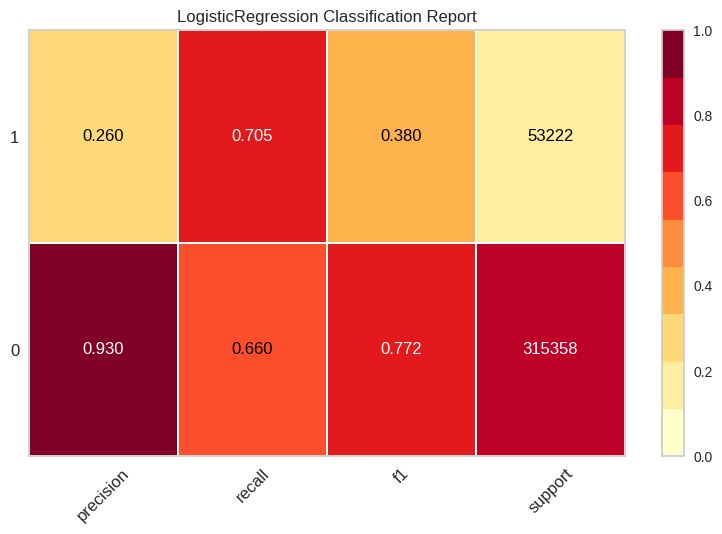

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [14]:
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression

viz = ClassificationReport(model, support=True)
viz.score(X_test, y_test)  # Just score + show
viz.show()

### 7.3 Confusion Matrix

<Figure size 600x400 with 0 Axes>

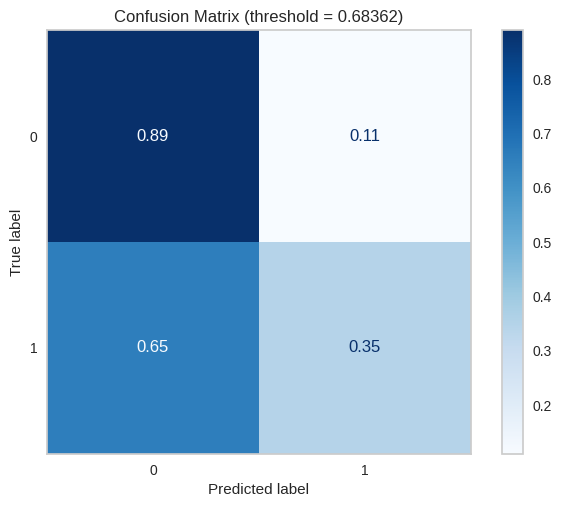

In [15]:
y_pred_thresh = (y_probs >= tuned_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_thresh, normalize="true")
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format=".2f")
plt.title(f"Confusion Matrix (threshold = {tuned_threshold:.5f})")
plt.grid(False)
plt.savefig("../reports/logistic_confusion_matrix.png")
plt.show();

In [16]:
beta = 2  # recall emphasis
f2_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-8)
f2_idx = np.argmax(f2_scores)
f2_threshold = thresholds[f2_idx]
print(f"Best F2 threshold: {f2_threshold:.5f}")


Best F2 threshold: 0.40549


In [17]:
beta = 0.5  # precision emphasis
f05_scores = (1 + beta**2) * (precision[:-1] * recall[:-1]) / (beta**2 * precision[:-1] + recall[:-1] + 1e-8)
f05_idx = np.argmax(f05_scores)
f05_threshold = thresholds[f05_idx]
print(f"Best F0.5 threshold: {f05_threshold:.5f}")


Best F0.5 threshold: 0.68551


In [18]:
print("\nF2-optimized classification report:")
print(classification_report(y_test, y_probs >= f2_threshold))

print("\nF0.5-optimized classification report:")
print(classification_report(y_test, y_probs >= f05_threshold))



F2-optimized classification report:
              precision    recall  f1-score   support

           0       0.95      0.51      0.66    315358
           1       0.22      0.84      0.35     53222

    accuracy                           0.56    368580
   macro avg       0.59      0.67      0.51    368580
weighted avg       0.84      0.56      0.62    368580


F0.5-optimized classification report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    315358
           1       0.35      0.34      0.34     53222

    accuracy                           0.81    368580
   macro avg       0.62      0.62      0.62    368580
weighted avg       0.81      0.81      0.81    368580



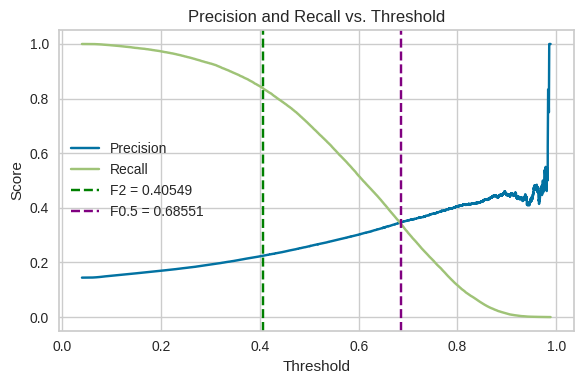

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

plt.axvline(f2_threshold, color="green", linestyle="--", label=f"F2 = {f2_threshold:.5f}")
plt.axvline(f05_threshold, color="purple", linestyle="--", label=f"F0.5 = {f05_threshold:.5f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


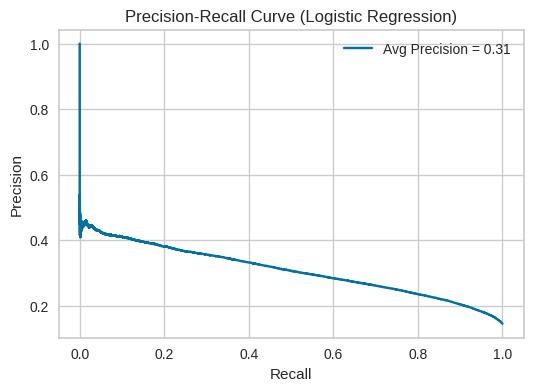

In [20]:
y_probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
#plt.savefig("../reports/logistic_precision_recall_curve.png")
plt.show()

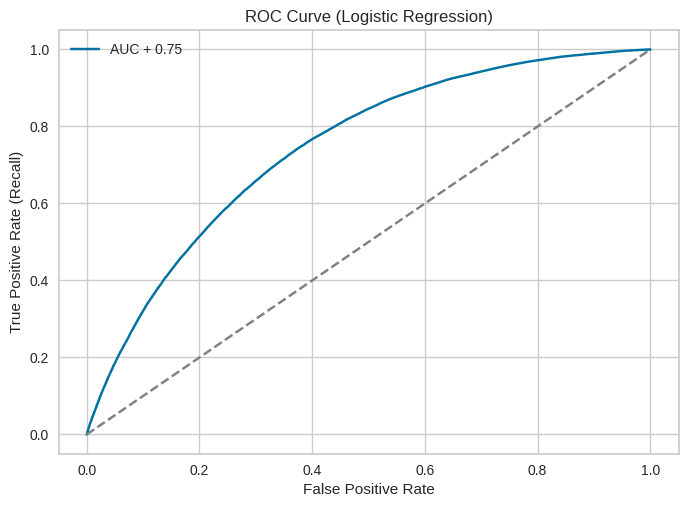

In [21]:
y_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC + {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Threshold tuning table
threshold_data = pd.DataFrame(
    {"threshold": thresholds_pr, "precision": precision[:-1], "recall": recall[:-1]}
)

threshold_data.head(20)

,threshold,precision,recall
0,0.039993,0.144397,1.0
1,0.041441,0.144398,1.0
2,0.041967,0.144398,1.0
3,0.043335,0.144399,1.0
4,0.043759,0.144399,1.0
5,0.044097,0.144399,1.0
6,0.044426,0.144400,1.0
7,0.044993,0.144400,1.0
8,0.045194,0.144401,1.0
9,0.045272,0.144401,1.0


In [23]:
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_probs)

threshold_data = pd.DataFrame(
    {
        "threshold": thresholds_pr,
        "precision": precision_vals[:-1],
        "recall": recall_vals[:-1],
    }
)

# Filter to better tradeoffs
threshold_data_filtered = threshold_data[
    (threshold_data["precision"] > 0.3) & (threshold_data["recall"] > 0.4)
].reset_index(drop=True)

threshold_data_filtered.head(20)

,threshold,precision,recall
0,0.595888,0.300001,0.526267
1,0.595893,0.300004,0.526267
2,0.595904,0.300033,0.526155
3,0.595905,0.300036,0.526155
4,0.595909,0.300038,0.526117
5,0.595910,0.300040,0.526098
6,0.595913,0.300045,0.526079
7,0.595915,0.300041,0.526061
8,0.595926,0.300047,0.526061
9,0.595945,0.300050,0.526061


              precision    recall  f1-score   support

           0       0.91      0.79      0.84    315358
           1       0.30      0.53      0.38     53222

    accuracy                           0.75    368580
   macro avg       0.60      0.66      0.61    368580
weighted avg       0.82      0.75      0.78    368580



<Figure size 500x400 with 0 Axes>

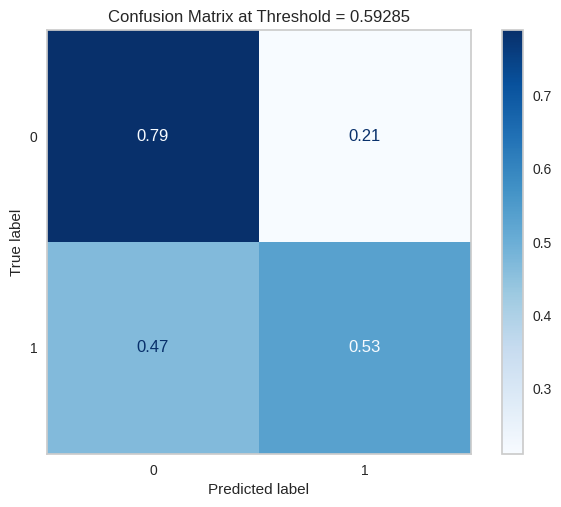

In [24]:
# why is threshold hard coded?

threshold = 0.59285
y_pred_thresh = (y_probs >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh))

# Show confusion matrix
cm = confusion_matrix(y_test, y_pred_thresh, normalize="true")
plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format=".2f")
plt.title(f"Confusion Matrix at Threshold = {threshold:.5f}")
plt.grid(False)
#plt.savefig("../reports/logistic_confusion_matrix.png")
plt.show()

In [25]:
# Find index where precision and recall are closest
pr_diff = np.abs(precision[:-1] - recall[:-1])
best_idx = np.argmin(pr_diff)
best_threshold = thresholds[best_idx]

print(f"Precision and Recall cross at threshold ≈ {best_threshold:.5f}")

Precision and Recall cross at threshold ≈ 0.68362


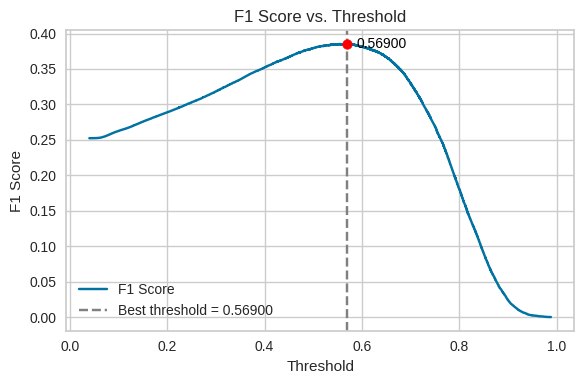

In [26]:
# Compute F1 manually (vectorized)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label="F1 Score")

# Mark best point
plt.axvline(
    best_threshold,
    linestyle="--",
    color="gray",
    label=f"Best threshold = {best_threshold:.5f}",
)
plt.scatter([best_threshold], [f1_scores[best_idx]], color="red", zorder=5)

# Annotate with text
plt.text(
    best_threshold + 0.02,
    f1_scores[best_idx],
    f"{best_threshold:.5f}",
    color="black",
    fontsize=10,
    va="center",
)

# Labels and formatting
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
#plt.savefig("../reports/logistic_f1_threshold_labeled.png")
plt.show()

## 8. Conclusion

We used logistic regression with SMOTE on 5 years of BRFSS data. While we observed modest predictive power, further steps could include:
- Feature importance analysis (e.g., SHAP)
- Compare with more advanced models (e.g., XGBoost)
- Apply interpretability tools

The pipeline is now ready for expansion.

In [27]:
time_spent = (time.time() - start_time) / 60

print(f"Notebook time: {time_spent:.2f} minutes")

Notebook time: 1.49 minutes
